In [1]:
# import pandas as pd 
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import matplotlib.pyplot as plt

# path = 'C:\\Users\\moham\\Desktop\\Third Year Project\\Dataset\\'

# columns = ['class','l_shoulder','r_shoulder','l_arm','r_arm','l_hip','r_hip','l_knee','r_knee']


# # y82_test = pd.read_csv(path+'y82_testing.csv', header=None)
# # y82_train = pd.read_csv(path+'y82_training.csv', header=None)
# # L_test = pd.read_csv(path+'L_testing.csv', header=None)
# # L_train = pd.read_csv(path+'y82_training.csv', header=None)

# # df_train = pd.concat([y82_train, L_train])
# # df_test = pd.concat([y82_test, L_test])

# # df_train.columns = columns
# # df_test.columns = columns


# # # factorize 
# # df_train['class'], classes = pd.factorize(df_train['class'])
# # df_test['class'], classes = pd.factorize(df_test['class'])

# # classes = list(classes)
# # df_test



# y82_test = pd.read_csv(path+'y82_testing.csv', header=None)
# y82_train = pd.read_csv(path+'y82_training.csv', header=None)
# L_test = pd.read_csv(path+'L_testing.csv', header=None)
# L_train = pd.read_csv(path+'y82_training.csv', header=None)

# df = pd.concat([y82_train, y82_test, L_test, L_train])

# df.columns = columns

# df['class'], classes = pd.factorize(df['class'])
# classes = list(classes)

# X = df.drop('class', axis=1)
# y = df['class']
# classes

['Chair', 'DownDog', 'Tree', 'WarriorIII', 'Cobra']

In [1]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import wandb

os.chdir('../Dataset')
path = os.getcwd()


columns = ['class','l_shoulder','r_shoulder','l_arm','r_arm','l_hip','r_hip','l_knee','r_knee']

y82_test = pd.read_csv(os.path.join(path,'y82_testing.csv'), header=None)
y82_train = pd.read_csv(os.path.join(path,'y82_training.csv'), header=None)
L_test = pd.read_csv(os.path.join(path,'L_testing.csv'), header=None)
L_train = pd.read_csv(os.path.join(path,'L_training.csv'), header=None)

combined_test = pd.concat([L_test, y82_test])
combined_train = pd.concat([L_train, y82_train])

combined_test.columns = columns 
combined_train.columns = columns 

combined_test['class'], classes = pd.factorize(combined_test['class'])
combined_train['class'], _ = pd.factorize(combined_train['class'])

classes = list(classes)


In [2]:
def split_features_labels(df):
    return df.drop('class', axis=1), df['class']

# HYPER PARAM SEARCHING FOR RANDOM FORESTS
### Kinda slow

In [4]:
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split

RANDOM_ORDER_DATA = True 
MAX_ESTIMATORS = 2
MAX_DEPTH = 2

if RANDOM_ORDER_DATA:
  mutated_data = combined_train.sample(frac=1)
else:
  mutated_data = combined_train

X_train, y_train = split_features_labels(mutated_data)
X_test, y_test = split_features_labels(combined_test)

forest_classifier = RandomForestClassifier()
param_grid = {'n_estimators' : np.arange(1, MAX_ESTIMATORS),
              'max_depth' : np.arange(1, MAX_DEPTH),
            }
forest_classifier_gscv = GridSearchCV(forest_classifier, param_grid, cv=5)

#fit model to data
# {'max_depth': 6, 'n_estimators': 73}
forest_classifier_gscv.fit(X_train, y_train)
forest_classifier_gscv.best_params_


{'max_depth': 1, 'n_estimators': 1}

# Testing out Wandb

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       103
           1       0.95      0.89      0.92       127
           2       0.87      0.93      0.90       188
           3       0.87      0.89      0.88       142
           4       0.96      0.96      0.96       142

    accuracy                           0.88       702
   macro avg       0.88      0.87      0.87       702
weighted avg       0.88      0.88      0.88       702



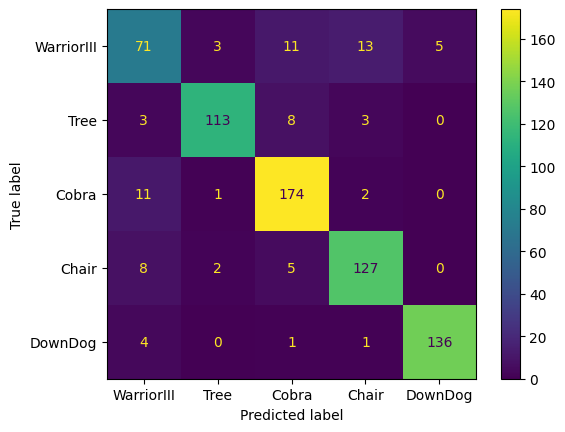

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
best_forest = RandomForestClassifier(max_depth=7, n_estimators=75)
best_forest.fit(X_train, y_train)

y_pred = best_forest.predict(X_test)
y_probas = best_forest.predict_proba(X_test)


cm = confusion_matrix(y_test, y_pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, y_pred))

# This takes ages, it's generating a whole image 

In [83]:
from sklearn import tree
def generate_tree():
    fn=columns
    cn=classes
    fig, axes = plt.subplots(nrows = 1, ncols = forest_classifier_gscv.n_estimators, figsize = (10,6), dpi=900)

    for tree_idx in range(forest_classifier_gscv.n_estimators):
        tree.plot_tree(forest_classifier_gscv.estimators_[tree_idx],
                    feature_names = fn, 
                    class_names=cn,
                    filled = True,
                    ax = axes[tree_idx]);
        axes[tree_idx].set_title('Estimator: ' + str(tree_idx), fontsize = 11)
        
    fig.savefig('rf_individualtree.png')
    

In [1]:
''' Increased value, means less trees will be plotted'''
TREE_STEP = 1
START_TREE = 1
END_TREE = 100


att = [x for x in forest_classifier_gscv.cv_results_]

scores = [x for x in forest_classifier_gscv.cv_results_['mean_test_score']]
times = [x for x in forest_classifier_gscv.cv_results_['mean_fit_time']]

scores = np.array(scores).reshape(MAX_ESTIMATORS-1, MAX_DEPTH-1)
times = np.array(times).reshape(MAX_ESTIMATORS-1, MAX_DEPTH-1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Mean Score / Time Against Max Depth and # Trees in Random Forest ')

for idx in range(START_TREE, END_TREE, TREE_STEP):
    ax1.plot(range(1, MAX_DEPTH), scores[idx-1], label='Estimators: ' + str(idx))
    ax2.plot(range(1, MAX_DEPTH), times[idx-1], label='Estimators: ' + str(idx))
    
ax1.set(xlabel='Depth', ylabel='Mean Score') 
ax2.set(xlabel='Depth', ylabel='Mean Time') 
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

NameError: name 'forest_classifier_gscv' is not defined

## Thoughts
From the graphs, it seems that the score growth is logarithmic and starts to slow down around the 4-5 mark in terms of number of estimators. Where as increasing the depth only marginally increases the score, there is a high jump at the beginning and rapidly decreases increase in score. 

In terms of time, it seems that the time take to fit these models are linear both in terms of depth and number of trees in the forest

# Intersting Note:
If we plot using estimators [0, 9] it looks very simialr to using estimators [0, 100, step=10]

### Feature Importance

According to the random forest model, the most important feature are the knees, followed by the hips then arms then shoulders.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


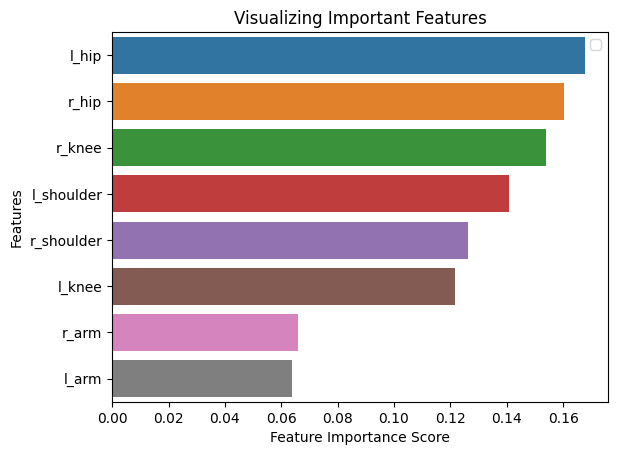

In [24]:
import seaborn as sns
max_depth = forest_classifier_gscv.best_params_['max_depth']
n_estimators = forest_classifier_gscv.best_params_['n_estimators']

X, y = split_features_labels(combined_train)

best_forest = RandomForestClassifier(max_depth = max_depth, n_estimators=n_estimators)
best_forest.fit(X, y)

feature_imp = pd.Series(best_forest.feature_importances_,index=columns[1:]).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()